# 4 premiers duels contre des schémas heuristiques

Episode 50/500 | epsilon=0.500 | avg=116.25
Episode 100/500 | epsilon=0.450 | avg=114.25
Episode 150/500 | epsilon=0.400 | avg=115.00
Episode 200/500 | epsilon=0.350 | avg=126.25
Episode 250/500 | epsilon=0.300 | avg=129.25
Episode 300/500 | epsilon=0.250 | avg=141.75
Episode 350/500 | epsilon=0.200 | avg=130.50
Episode 400/500 | epsilon=0.150 | avg=141.00
Episode 450/500 | epsilon=0.100 | avg=136.00
Episode 500/500 | epsilon=0.050 | avg=140.00


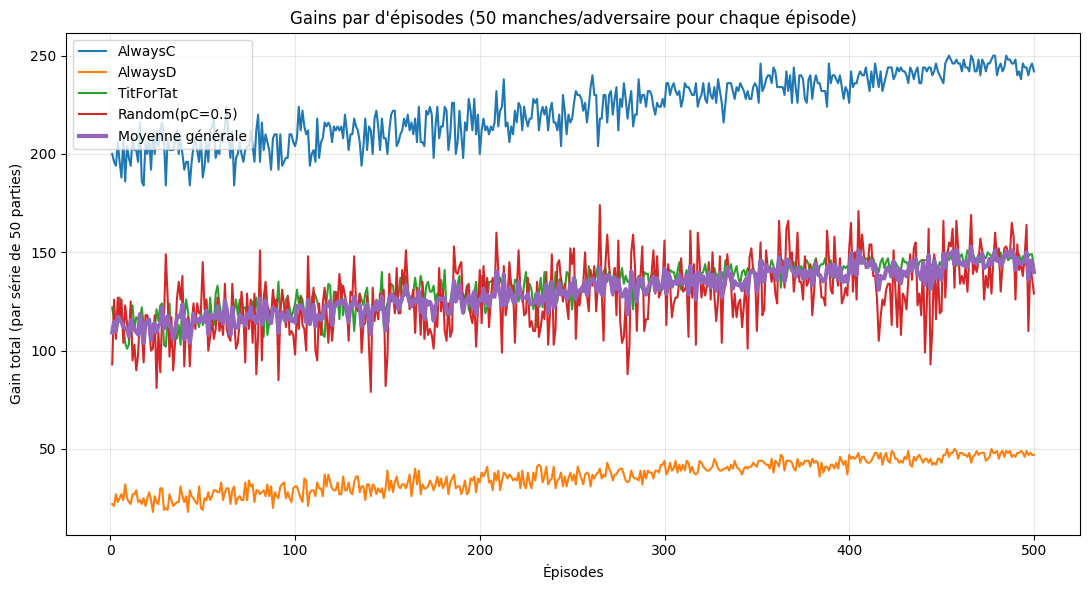

Q-table sauvegardée dans trained_agent_qtable.npz


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

# ============================================================
# 1) Prisoner's Dilemma (payoffs)
# Actions: 0 = Cooperate (C), 1 = Defect (D)
# Payoffs (agent, opponent):
#   (C,C) -> (R,R)
#   (C,D) -> (S,T)
#   (D,C) -> (T,S)
#   (D,D) -> (P,P)
# Classic constraints: T > R > P > S
# ============================================================

R = 3  # reward for mutual cooperation
T = 5  # temptation to defect
P = 1  # punishment for mutual defection
S = 0  # sucker's payoff

PAYOFF_AGENT = {
    (0, 0): R,
    (0, 1): S,
    (1, 0): T,
    (1, 1): P
}

# ============================================================
# 2) Opponent strategies
# Each opponent has a method act(t, my_last, opp_last, history)
# where "my" refers to opponent itself, "opp" refers to agent.
# ============================================================


# On définit une classe de base pour tous nos adversaires, et ensuite on spécifie leurs actions pour chacun d'eux
class OpponentBase:
    name = "Base"
    def reset(self):
        pass
    def act(self, t, agent_last_action):
        raise NotImplementedError

# Pour l'adversaire qui coopère toujours
class AlwaysCooperate(OpponentBase):
    name = "AlwaysC"
    def act(self, t, agent_last_action):
        return 0

# Pour l'adversaire qui trahis toujours 
class AlwaysDefect(OpponentBase):
    name = "AlwaysD"
    def act(self, t, agent_last_action):
        return 1

# Pour l'agent Tit-For-Tat
class TitForTat(OpponentBase):
    name = "TitForTat"
    def act(self, t, agent_last_action):
        return 0 if t == 0 else agent_last_action

# Pour l'agent Random
class Random05(OpponentBase):
    name = "Random(pC=0.5)"
    def __init__(self, seed=None):
        self.rng = np.random.default_rng(seed)
    def act(self, t, agent_last_action):
        return int(self.rng.integers(0, 2))  # 0 ou 1, p=0.5
    
# Il est à noter ici que ces quatre agents ne réflechissent pas et donc 
# il n'est pas nécessaire de leur coder un système de gain.



# ============================================================
# 3) Learning Agent: Q-Learning tabulaire (adaptatif par adversaire)
# ============================================================

# On code un agent Q-learning simple qui apprend une politique.
# Pour qu'il "s'adapte" à l'adversaire, on inclut l'identité de l'adversaire
# dans l'état (opp_id). Ainsi l'agent peut apprendre une stratégie différente
# contre AlwaysC, AlwaysD, TitForTat, Random, etc.

START = 2  # code spécial pour "pas d'action précédente" (ni agent, ni adversaire)

def last_pair_to_index(a_last, o_last):
    """
    Mappe (a_last, o_last) -> index dans {0..4}
    0: START/START
    1: (C,C)
    2: (C,D)
    3: (D,C)
    4: (D,D)
    """
    if a_last == START and o_last == START:
        return 0
    if a_last == 0 and o_last == 0:
        return 1
    if a_last == 0 and o_last == 1:
        return 2
    if a_last == 1 and o_last == 0:
        return 3
    if a_last == 1 and o_last == 1:
        return 4
    raise ValueError("Couple (a_last, o_last) invalide.")

def make_state_index(opp_id, a_last, o_last):
    """
    Etat = (opp_id, dernier coup agent, dernier coup adversaire)
    Nombre d'états: 4 adversaires * 5 couples = 20 états.
    """
    pair_idx = last_pair_to_index(a_last, o_last)  # 0..4
    return opp_id * 5 + pair_idx  # 0..19

NUM_OPP = 4
NUM_STATES = NUM_OPP * 5
NUM_ACTIONS = 2  # C ou D

class QLearningAgent:
    def __init__(self, alpha=0.10, gamma=0.95, epsilon=0.50, seed=123):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rng = np.random.default_rng(seed)
        self.Q = np.zeros((NUM_STATES, NUM_ACTIONS), dtype=float)

    def greedy_action(self, s_idx):
        q = self.Q[s_idx]
        best_actions = np.flatnonzero(q == q.max())
        return int(self.rng.choice(best_actions))

    def select_action(self, s_idx):
        """
        ε = probabilité de prendre une action NON-greedy (si possible).
        """
        a_star = self.greedy_action(s_idx)

        # exploration
        if self.rng.random() < self.epsilon:
            # prendre autre chose que la meilleure (si possible)
            other_actions = [a for a in range(NUM_ACTIONS) if a != a_star]
            if other_actions:
                return int(self.rng.choice(other_actions))
            return a_star  # sécurité (cas NUM_ACTIONS=1, ici non)
        # exploitation
        return a_star

    def update(self, s_idx, action, reward, s_next_idx):
        target = reward + self.gamma * np.max(self.Q[s_next_idx])
        self.Q[s_idx, action] += self.alpha * (target - self.Q[s_idx, action])


# ============================================================
# 4) Interaction: un match (plusieurs manches) vs un adversaire
# ============================================================

def play_match(agent, opponent, opp_id, rounds=50, learn=True):
    """
    Joue un match de 'rounds' manches contre un adversaire.
    Retourne le gain total de l'agent sur ce match.
    """
    opponent.reset()

    a_last = START
    o_last = START
    total_reward = 0.0

    for t in range(rounds):
        s_idx = make_state_index(opp_id, a_last, o_last)

        # action agent
        a = agent.select_action(s_idx)

        # action adversaire (il reçoit l'action précédente de l'agent)
        # au premier tour, on passe 0 par convention (cooperer) car l'adversaire ignore ou gère t==0.
        agent_last_for_opp = 0 if a_last == START else a_last
        o = opponent.act(t, agent_last_for_opp)

        # récompense agent
        r = PAYOFF_AGENT[(a, o)]
        total_reward += r

        # transition
        a_next, o_next = a, o
        s_next_idx = make_state_index(opp_id, a_next, o_next)

        if learn:
            agent.update(s_idx, a, r, s_next_idx)

        a_last, o_last = a_next, o_next

    return total_reward


# ============================================================
# 5) Entraînement: 1 épisode = 1 match contre chacun des 4 adversaires
# ============================================================

def epsilon_schedule_step(ep, eps_start=0.50, eps_end=0.05, step_size=50, total_episodes=1000):
    """
    ep: épisode courant (0-indexé)
    paliers de step_size épisodes, linéaire en paliers de eps_start à eps_end.
    """
    num_levels = int(np.ceil(total_episodes / step_size))  # ici 20
    # niveaux: 0..num_levels-1
    level = min(ep // step_size, num_levels - 1)

    if num_levels == 1:
        return eps_end

    delta = (eps_start - eps_end) / (num_levels - 1)
    eps = eps_start - level * delta
    return float(max(eps_end, eps))

def train(agent, opponents, episodes=1000, rounds_per_match=50,
          eps_start=0.50, eps_end=0.05, eps_step=50):
    gains_by_opp = {opp.name: [] for opp in opponents}
    avg_all = []
    eps_history = []

    for ep in range(episodes):
        # epsilon par palier
        agent.epsilon = epsilon_schedule_step(
            ep,
            eps_start=eps_start,
            eps_end=eps_end,
            step_size=eps_step,
            total_episodes=episodes
        )
        eps_history.append(agent.epsilon)

        ep_rewards = []
        for opp_id, opp in enumerate(opponents):
            rew = play_match(agent, opp, opp_id=opp_id, rounds=rounds_per_match, learn=True)
            gains_by_opp[opp.name].append(rew)
            ep_rewards.append(rew)

        avg_all.append(float(np.mean(ep_rewards)))

        # (optionnel) log tous les 50 épisodes
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}/{episodes} | epsilon={agent.epsilon:.3f} | avg={avg_all[-1]:.2f}")

    return gains_by_opp, avg_all, eps_history



# ============================================================
# 6) Graphique
# ============================================================

def plot_results(gains_by_opp, avg_all, title="Évolution des gains par épisode par adversaire"):
    x = np.arange(1, len(avg_all) + 1)

    plt.figure(figsize=(11, 6))
    for name, rewards in gains_by_opp.items():
        plt.plot(x, rewards, label=name)

    plt.plot(x, avg_all, linewidth=3, label="Moyenne générale")

    plt.xlabel("Épisodes")
    plt.ylabel("Gain total (par série de 50 parties)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# 7) Lancement
# ============================================================

if __name__ == "__main__":
    opponents = [
        AlwaysCooperate(),
        AlwaysDefect(),
        TitForTat(),
        Random05(seed=42),
    ]

    agent = QLearningAgent(
        alpha=0.10,
        gamma=0.95,
        epsilon=0.30,
        seed=123
    )

    gains_by_opp, avg_all, eps_history = train(
        agent,
        opponents,
        episodes=500,
        rounds_per_match=50
    )


    plot_results(
        gains_by_opp,
        avg_all,
        title="Gains par d'épisodes (50 manches/adversaire pour chaque épisode)"
    )

# ============================================================
# 8) Sauvegarde de l'apprentissage
# ============================================================

np.savez(
    "trained_agent_qtable.npz",
    Q=agent.Q,
    alpha=agent.alpha,
    gamma=agent.gamma,
    epsilon=agent.epsilon
)

print("Q-table sauvegardée dans trained_agent_qtable.npz")







